In [1]:
from pathlib import Path  
from typing import Optional, List, Dict, Tuple 
import pandas as pd
import numpy as np
import collections  
from pprint import pprint 
from who_member_states import WHO_MEMBER_STATES

In [2]:

__all__ = ['select_df']  # only import 'select_df'


# test data should <10 MB

def select_df(df: pd.DataFrame,
              rename_mapping: Dict[str, str] = None,
              column_drop: Optional[List[str]] = None,  # column_drop (param) is an optional list of string. Optional
              # type is from Typing. default is None (no drop any column). If provide column_drop, must be ['xxx'] (
              # list of string)
              year: int = 2000,
              save_path: Optional[Path] = None,
              drop_na: Optional[List[str]] = None, ) -> pd.DataFrame:
    """
    dataframe modification and save as another file

    :param df: input dataframe
    :param rename_mapping: both df have countries but the header is different
    :param column_drop: drop the column(s) that are not informative
    :param year: pick up the data that larger than which year
    :param save_path: path for saving the modified dataframe
    :param drop_na: specify if drop the na-existing column name
    :return: modified df
    """

    df = df.copy()  # The copy() method returns a copy of the DataFrame. By default, the copy is a "deep copy"
    # meaning that any changes  made in the original DataFrame will NOT be reflected in the copy. 新跑出來的df不會影響最原始的df

    if rename_mapping is not None:
        df = df.rename(columns=rename_mapping)
    if column_drop is not None:  # if drop specific column,df need to drop the option
        df = df.drop(columns=column_drop)  # df 的column = column after drop, column_drop: Optional[List[str]]

    year_mask: pd.Series[bool] = df['Year'] >= year  # type is list of bool; compared df["year"] whether larger than
    # default year (year: int = 2000)
    #    entity_mask: List[bool] = [country in WHO_MEMBER_STATES for country in
    #                              df['Country Name']]  # check countries whether
    # in df['Entity'] also in WHO_MEMBER_STATES. If Yes =True
    modified_df: pd.DataFrame = df[year_mask].reset_index(
        drop=True)  # create a new df that only meet both
    # year_mask and entity_mask. df.reset_index(drop = True) means new index created, old index don't added in new df.

    if drop_na is not None:  # drop rows with missing values ('NaN') from df
        try:
            modified_df.dropna(subset=drop_na, inplace=True)
            # inplace = True means that the original df will be modified and no copy will be made.; But, if inplace =
            # False, df will still show the initial one. subset = drop_na means drop in specific place you set.
        except KeyError as e:
            raise ValueError(f'{e} not in the dataframe, should be one of the {modified_df.columns.tolist()}')  # If
            # typed wrong, show the list which should be dropped.
    if save_path is not None:
        modified_df.to_excel(save_path)

    return modified_df


In [3]:
if __name__ == '__main__':
    raw_who_cvd_df = pd.read_csv('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/raw data/WHOMortalityDatabase_Deaths_sex_age_a_country_area_year-Cardiovascular diseases_7th February 2023.csv')
column_drop = ['Age group code', 'Unnamed: 12']
na_header = ['Number',
             'Percentage of cause-specific deaths out of total deaths',
             'Death rate per 100 000 population']
save_path = (
    '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHO_Cardiovascular_Disease_Mortality_Database.xlsx')
who_cvd_df = select_df(raw_who_cvd_df, column_drop=column_drop, drop_na=na_header,
                       save_path=save_path)

In [4]:
number_of_countries=raw_who_cvd_df['Country Name'].unique()
print(len(number_of_countries),raw_who_cvd_df.shape, raw_who_cvd_df.columns.tolist())
print(max(raw_who_cvd_df['Year']))
print(min(raw_who_cvd_df['Year']))

114 (297066, 13) ['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age group code', 'Age Group', 'Number', 'Percentage of cause-specific deaths out of total deaths', 'Age-standardized death rate per 100 000 standard population', 'Death rate per 100 000 population', 'Unnamed: 12']
2020
1950


In [5]:
print(len(who_cvd_df['Country Name'].unique()),who_cvd_df.shape,who_cvd_df.columns.tolist())

111 (111401, 11) ['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age Group', 'Number', 'Percentage of cause-specific deaths out of total deaths', 'Age-standardized death rate per 100 000 standard population', 'Death rate per 100 000 population']


In [6]:
# 計算每列中的缺失值總數
print(raw_who_cvd_df.isna().sum(axis=0))

print(raw_who_cvd_df.isna().sum().sum())

Region Code                                                         0
Region Name                                                         0
Country Code                                                        0
Country Name                                                        0
Year                                                                0
Sex                                                                 0
Age group code                                                      0
Age Group                                                           0
Number                                                           1593
Percentage of cause-specific deaths out of total deaths          9763
Age-standardized death rate per 100 000 standard population    283341
Death rate per 100 000 population                               25020
Unnamed: 12                                                    297066
dtype: int64
616783


In [7]:

def preprocess_cvd(df: pd.DataFrame,
                   drop_na: Optional[List[str]] = None,
                   save_path: Optional[Path] = None) -> pd.DataFrame:
    """
    Dataframe of WHO_Cardiovascular_Disease_Mortality_Database.xlsx need to modify:
    - grouping if set kwarg `grouping_age` as true  # kwarg : keyword arguments
    - Calculate Total number of death
    - only left age >15 years old
    - save as another dataframe

    :param df: input dataframe (WHO_Cardiovascular_Disease_Mortality_Database.xlsx)
    :param drop_na: drop Age_Group <15 year-old
    :param save_path: save modified dataframe to another excel
    :return: df
    """

    # Sum of number of death in each age group
    numbers = df['Number']
    percentage = df['Percentage of cause-specific deaths out of total deaths']
    df["Total Number of Deaths"] = numbers * 100 / percentage
    total_number_of_death = df["Total Number of Deaths"]
    mask_nan = np.isnan(total_number_of_death)  # type: pd.Series[bool] # if value is NaN, NaN = True

    df.loc[
        mask_nan, "Total Number of Deaths"] = 0  # search location of df. if index ('Total number of death') is
    # NaN, change NaN to 0. ( if no.loc :SettingWithCopyWarning: A value is trying to be set on a copy of a slice
    # from a DataFrame
    df["Total Number of Deaths"] = df["Total Number of Deaths"].astype(
        int)  # astype can cast/change multiple types (
    # change type to int)
    if drop_na is not None:  # drop rows with missing values ('NaN') from df
        df = df.mask(df['Age Group'].isin(['[0]', '[1-4]', '[5-9]', '[10-14]','[All]']), np.nan)
        df.dropna(subset=['Age Group'], inplace=True)

    if save_path is not None:
        df.to_excel(save_path)
    return df

In [8]:
who_cvd_df= pd.read_excel('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHO_Cardiovascular_Disease_Mortality_Database.xlsx')
# “xlrd” supports old-style Excel files (.xls).“openpyxl” supports newer Excel file formats.
drop_na =['Age Group']
save_path=('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHO_Cardiovascular_Disease_Mortality_Database_preprocess.xlsx')
who_cvd_df_preprocess = preprocess_cvd(who_cvd_df,drop_na= drop_na,save_path=save_path)  # assign a who_cvd_df after preprocess_cvd
print(len(who_cvd_df_preprocess['Country Name'].unique()),who_cvd_df_preprocess.shape,who_cvd_df_preprocess.columns.tolist())

110 (83584, 13) ['Unnamed: 0', 'Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'Sex', 'Age Group', 'Number', 'Percentage of cause-specific deaths out of total deaths', 'Age-standardized death rate per 100 000 standard population', 'Death rate per 100 000 population', 'Total Number of Deaths']


In [9]:

def create_age_grouping(df: pd.DataFrame,
                        save_path: Optional[Path] = None) -> pd.DataFrame:
    """
    Calculate: Total percentage of CVD of total deaths = Sum of number/ Sum of Total number of cause-specific deaths
    * 100 (Male/ Female/ All in each year and country)
    grouping_age: Age groups --> one age group (greater 15 y/o)
    create a new df and save it to excel

    :param df: df after select_df and preprocess_cvd
    :param save: save modified dataframe to another excel
    :return: new df
    """

    if 'Total Number of Deaths' not in df.columns:
        raise RuntimeError('call preprocess_cvd in advance')

    dy: dict = collections.defaultdict(list)  # defaultdict object in collections. datatype will be dict. Using list
    # as the default_factory to group a sequence of key-value pairs into a dictionary of lists
    group = df.groupby(['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'Sex'])
    info: List[Tuple] = list(group.groups.keys())  # List[Tuple]: value is a list of tuple[()].looking for the keys in a
    # dict. The 'groups' attribute of the 'groupby' object is always dic type

    for i, it in enumerate(info):  # i = index ( starting from 0) , it = item (Entity, Year, Sex). enumerate can pair
        # index and item
        dy['Region Code'].append(it[0])
        dy['Region Name'].append(it[1])
        dy['Country Code'].append(it[2])
        dy['Country Name'].append(it[3])
        dy['Year'].append(it[4])  # Year in [4]
        dy['Sex'].append(it[5])  # Sex in [5]

    numbers = group['Number']
    total_number_of_death = group['Total Number of Deaths']
    # noinspection PyTypeChecker todo: wt is it?
    dy['Number'] = np.array(numbers.sum())
    dy['Total Number of Deaths'] = np.array(total_number_of_death.sum())
    dy['Total Percentage of Cause-Specific Deaths Out Of Total Deaths'] = np.array(
        numbers.sum() / total_number_of_death.sum() * 100)

    _df = pd.DataFrame.from_dict(dy)  # creates a new_df from the dy dictionary.

    # change layout
    sex_values = ['All', 'Female', 'Male']
    new_df = _df.assign(
        All_Number_of_Cause_Specific_Deaths=_df.query("Sex == 'All'")['Number'],
        Female_Number_of_Cause_Specific_Deaths=_df.query("Sex == 'Female'")['Number'],
        Male_Number_of_Cause_Specific_Deaths=_df.query("Sex == 'Male'")['Number'],
        All_Total_Number_of_Deaths=_df.query("Sex == 'All'")['Total Number of Deaths'],
        Female_Total_Number_of_Deaths=_df.query("Sex == 'Female'")[
            'Total Number of Deaths'],
        Male_Total_Number_of_Deaths=_df.query("Sex == 'Male'")['Total Number of Deaths'],
        All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths=_df.query("Sex == 'All'")[
            'Total Percentage of Cause-Specific Deaths Out Of Total Deaths'],
        Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths=_df.query("Sex == 'Female'")[
            'Total Percentage of Cause-Specific Deaths Out Of Total Deaths'],
        Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths=_df.query("Sex == 'Male'")[
            'Total Percentage of Cause-Specific Deaths Out Of Total Deaths'])
    new_df.reset_index(drop=True, inplace=True)

    new_df = new_df.drop(['Sex', 'Number', 'Total Number of Deaths',
                          'Total Percentage of Cause-Specific Deaths Out Of Total Deaths'],
                         axis=1)  # axis = 1: specifies to drop columns

    new_df = new_df.groupby(['Region Code', 'Region Name', 'Country Code', 'Country Name',
                             'Year']).first().reset_index()  # The first method is then applied to
    # the grouped dataframe, which returns the first row of each group
    if save_path:
        new_df.to_excel(save_path)
    return new_df


In [10]:
who_cvd_df_preprocess = pd.read_excel('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHO_Cardiovascular_Disease_Mortality_Database_preprocess.xlsx')
who_cvd_df_preprocess= preprocess_cvd(who_cvd_df_preprocess)
save_path = ('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/new_WHO_Cardiovascular_Disease_Mortality_Database.xlsx')
new_df = create_age_grouping(who_cvd_df_preprocess,save_path=save_path)
print(len(new_df['Country Name'].unique()),new_df.shape,new_df.columns.tolist())

110 (1860, 14) ['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'All_Number_of_Cause_Specific_Deaths', 'Female_Number_of_Cause_Specific_Deaths', 'Male_Number_of_Cause_Specific_Deaths', 'All_Total_Number_of_Deaths', 'Female_Total_Number_of_Deaths', 'Male_Total_Number_of_Deaths', 'All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths']


In [11]:

def tobacco_layout_modified(df: pd.DataFrame,
                            column_drop: Optional[Path] = None,
                            save_path: Optional[Path] = None) -> pd.DataFrame:
    if column_drop is not None:
        df = df.drop(columns=column_drop)
    dy: dict = collections.defaultdict(list)
    group = df.groupby(['Country Name', 'Year', 'Indicator', 'Sex'])
    info: List[Tuple] = list(group.groups.keys())

    for i, it in enumerate(info):
        dy['Country Name'].append(it[0])
        dy['Year'].append(it[1])
        dy['Indicator'].append(it[2])
        dy['Sex'].append(it[3])
        dy['Prevalence'].append(group.get_group(it).Prevalence.mean())

    _df = pd.DataFrame.from_dict(dy)
    sex_values = ['Both sexes', 'Male', 'Female']
    indicator_values = ['Estimate of current tobacco use prevalence (%) (age-standardized rate)',
                        'Estimate of current tobacco smoking prevalence (%) (age-standardized rate)',
                        'Estimate of current cigarette smoking prevalence (%) (age-standardized rate)']

    changed_df = _df.assign(
        All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Both sexes'& Indicator =='Estimate of current tobacco use prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Male'& Indicator =='Estimate of current tobacco use prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Female'& Indicator =='Estimate of current tobacco use prevalence (%) (age-standardized rate)'")[
            'Prevalence'],

        All_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Both sexes'& Indicator =='Estimate of current tobacco smoking prevalence (%) (age-standardized "
            "rate)'")['Prevalence'],
        Male_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Male'& Indicator =='Estimate of current tobacco smoking prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        Female_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate=_df.query(
            "Sex == 'Female'& Indicator =='Estimate of current tobacco smoking prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        All_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate=_df.query(
            "Sex == 'Both sexes'& Indicator =='Estimate of current cigarette smoking prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        Male_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate=_df.query(
            "Sex == 'Male'& Indicator =='Estimate of current cigarette smoking prevalence (%) (age-standardized rate)'")[
            'Prevalence'],
        Female_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate=_df.query(
            "Sex == 'Female'& Indicator =='Estimate of current cigarette smoking prevalence (%) (age-standardized rate)'")[
            'Prevalence'])

    changed_df.reset_index(drop=True, inplace=True)

    changed_df = changed_df.drop(['Sex', 'Prevalence', 'Indicator'], axis=1)
    changed_df = changed_df.groupby(['Country Name', 'Year']).first().reset_index()
    print(changed_df)
    if save_path is not None:
        changed_df.to_excel(save_path)
    return changed_df

In [12]:
raw_tobacco_df = pd.read_csv(
    '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/raw data/Estimate of current tobacco smoking '
    'prevalence(%)(age-standardized rate)_17 Jan 2022.csv')

rename = {'Location': 'Country Name', 'Period': 'Year', 'Dim1': 'Sex', 'First Tooltip': 'Prevalence'}

save_path = '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/Prevalence of Tobacco use_modified.xlsx'
tobacco_df = select_df(raw_tobacco_df, rename_mapping=rename, save_path=save_path)
print(len(raw_tobacco_df['Location'].unique()),raw_tobacco_df.shape,raw_tobacco_df.columns.tolist())
print(len(tobacco_df['Country Name'].unique()),tobacco_df.shape,tobacco_df.columns.tolist())
print(min(raw_tobacco_df['Period']))
print(max(raw_tobacco_df['Period']))

165 (9351, 5) ['Location', 'Period', 'Indicator', 'Dim1', 'First Tooltip']
165 (9351, 5) ['Country Name', 'Year', 'Indicator', 'Sex', 'Prevalence']
2000
2025


In [104]:
print(raw_tobacco_df.isna().sum(axis=0))

print(raw_tobacco_df.isna().sum().sum())

Location         0
Period           0
Indicator        0
Dim1             0
First Tooltip    0
dtype: int64
0


In [109]:
tobacco_df = pd.read_excel(
    '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/Prevalence of Tobacco use_modified.xlsx')

save_path = '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/Prevalence of Tobacco use_Changed_layout.xlsx'
changed_df = tobacco_layout_modified(tobacco_df, save_path=save_path)

print(len(changed_df['Country Name'].unique()),changed_df.shape,changed_df.columns.tolist())


     Country Name  Year  \
0     Afghanistan  2000   
1     Afghanistan  2005   
2     Afghanistan  2010   
3     Afghanistan  2015   
4     Afghanistan  2018   
...           ...   ...   
1472     Zimbabwe  2018   
1473     Zimbabwe  2019   
1474     Zimbabwe  2020   
1475     Zimbabwe  2023   
1476     Zimbabwe  2025   

      All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate  \
0                                                  36.9                      
1                                                  32.7                      
2                                                  29.1                      
3                                                  26.0                      
4                                                  23.8                      
...                                                 ...                      
1472                                               12.1                      
1473                                               

165 (1477, 11) ['Country Name', 'Year', 'All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'All_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate', 'Male_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate', 'Female_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate', 'All_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate', 'Male_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate', 'Female_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate']


In [119]:
# merge df1 & df2 test
df1 = new_df
df2 = changed_df

cvd_tobacco = pd.merge(df1, df2, on=['Country Name', 'Year'], how='outer')
cvd_tobacco.fillna(value='NaN',inplace=True)  # inplace = True means that 'value = 'NaN'' will inplace original value in df. 'Nan' can changed what you want to instead of.

# drop no need indicators in Tobacco dataset
columns_to_drop = [
    'Female_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate',
    'Male_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate',
    'All_Estimate_of_current_cigarette_smoking_prevalence_age_standardized_rate',
    'Female_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate',
    'Male_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate',
    'All_Estimate_of_Current_Tobacco_Smoking_Prevalence_age_standardized_rate'
]
cvd_tobacco = cvd_tobacco.drop(columns=columns_to_drop)

cvd_tobacco.to_excel(
    '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/merge_cvd_tobacco.xlsx')
print(len(cvd_tobacco['Country Name'].unique()),cvd_tobacco.shape, cvd_tobacco.columns.tolist())


185 (2881, 17) ['Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'All_Number_of_Cause_Specific_Deaths', 'Female_Number_of_Cause_Specific_Deaths', 'Male_Number_of_Cause_Specific_Deaths', 'All_Total_Number_of_Deaths', 'Female_Total_Number_of_Deaths', 'Male_Total_Number_of_Deaths', 'All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate']


In [120]:

# drop NaN
cvd_tobacco.replace('NaN', np.nan, inplace=True)
cvd_tobacco = cvd_tobacco.dropna(axis=0)

cvd_tobacco.to_excel(
    '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/cvd_tobacco_nomissingdata.xlsx')

In [113]:
def format_date(df: pd.DataFrame,
                rename_mapping: Dict[str, str] = None,
                formatted_date: Optional[List[str]] = None,
                save_path: Optional[Path] = None) -> pd.DataFrame:
    if rename_mapping is not None:
        df = df.rename(columns=rename_mapping)
    if formatted_date is not None:
        for col in formatted_date:
            df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
            df[col] = df[col].dt.strftime("%d %b %Y")
    df.fillna(value='Nan', inplace=True)
    if save_path is not None:
        df.to_excel(save_path)
    return df

In [91]:
if __name__ == '__main__':
    df = pd.read_excel(
        '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/raw data/Signatures and Ratifications- UN '
        'Treaty Section_08 Feb_2023_Name chnaged.xlsx',
        engine='openpyxl')
    rename = {'Participant': 'Country Name',
              "Ratification, Acceptance(A), Approval(AA), Formal confirmation(c), Accession(a), Succession(d)": 'Ratification'}
    formatted_date = ['Signature', 'Ratification']
    save_path = '/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHOFCTC_Parties_date_formatted.xlsx'
    df=format_date(df, rename_mapping=rename, formatted_date=formatted_date, save_path=save_path)


In [84]:
print(len(df['Country Name'].unique()),df.shape,df.columns.tolist())

188 (188, 3) ['Country Name', 'Signature', 'Ratification']


In [121]:
# merge
df1 = pd.read_excel('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/cvd_tobacco_nomissingdata.xlsx',
                    engine='openpyxl')
df2 = pd.read_excel('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHOFCTC_Parties_date_formatted.xlsx',
                    engine='openpyxl')

signed_df = pd.merge(df1, df2, on=['Country Name'], how='outer')
signed_df.fillna(value='NaN', inplace=True)
signed_df.to_excel('/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHOFCTC_Parties_signed_date.xlsx')

In [122]:
print(signed_df.eq('NaN').sum().sum())
print(signed_df.eq('Nan').sum().sum())

1700
75


In [123]:
print(len(signed_df['Country Name'].unique()),signed_df.shape,signed_df.columns.tolist())

188 (556, 21) ['Unnamed: 0_x', 'Region Code', 'Region Name', 'Country Code', 'Country Name', 'Year', 'All_Number_of_Cause_Specific_Deaths', 'Female_Number_of_Cause_Specific_Deaths', 'Male_Number_of_Cause_Specific_Deaths', 'All_Total_Number_of_Deaths', 'Female_Total_Number_of_Deaths', 'Male_Total_Number_of_Deaths', 'All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths', 'All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate', 'Unnamed: 0_y', 'Signature', 'Ratification']


In [124]:
# drop_missing_data
signed_df.replace('NaN', np.nan, inplace=True)
signed_df = signed_df.dropna(axis=0)

signed_df.to_excel("/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/WHOFCTC_Parties_date_no_missingdata.xlsx")


In [125]:
print(signed_df['Country Name'].unique(), len(signed_df['Country Name'].unique()), signed_df.shape,signed_df.columns.tolist())


['Egypt' 'Mauritius' 'South Africa' 'Armenia' 'Azerbaijan' 'Bahrain'
 'Brunei Darussalam' 'Cyprus' 'Georgia' 'Iran (Islamic Republic of)'
 'Iraq' 'Israel' 'Jordan' 'Japan' 'Kazakhstan' 'Kyrgyzstan'
 'Republic of Korea' 'Kuwait' 'Lebanon' 'Sri Lanka' 'Maldives'
 'Philippines' 'Singapore' 'Thailand' 'Turkmenistan' 'Uzbekistan'
 'Argentina' 'Belize' 'Brazil' 'Chile' 'Colombia' 'Costa Rica' 'Ecuador'
 'Guatemala' 'Guyana' 'Mexico' 'Panama' 'Peru' 'Paraguay' 'El Salvador'
 'Uruguay' 'Albania' 'Austria' 'Belgium' 'Bulgaria'
 'Bosnia and Herzegovina' 'Belarus' 'Switzerland' 'Czechia' 'Germany'
 'Denmark' 'Spain' 'Estonia' 'Finland' 'France' 'Greece' 'Croatia'
 'Hungary' 'Ireland' 'Iceland' 'Italy' 'Lithuania' 'Luxembourg' 'Latvia'
 'Republic of Moldova' 'Malta' 'Montenegro' 'Netherlands' 'Norway'
 'Poland' 'Portugal' 'Romania' 'Russian Federation' 'Serbia' 'Slovakia'
 'Slovenia' 'Sweden' 'Ukraine' 'Bahamas' 'Barbados' 'Canada' 'Cuba'
 'Dominican Republic' 'Jamaica' 'United States of America' 

In [126]:

counts_df = signed_df['Country Name'].value_counts().to_frame()

counts_df.columns = ['count']
counts_df.to_excel("/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/count_country.xlsx")


Estonia
Costa Rica
Mexico
Czechia
Netherlands
Georgia
Spain
Singapore
Latvia
Germany
Guatemala
Kazakhstan
Austria
Serbia
Lithuania
Ecuador
Iceland
Slovenia
Mauritius

In [127]:
# 找出所有包含指定值的行
result_df = signed_df[signed_df.isin(
    ['Estonia', 'Costa Rica', 'Mexico', 'Czechia', 'Netherlands', 'Georgia', 'Spain', 'Singapore', 'Latvia', 'Germany',
     'Guatemala', 'Kazakhstan', 'Austria', 'Serbia', 'Lithuania', 'Ecuador', 'Iceland', 'Slovenia', 'Mauritius',
     ]).any(axis=1)].dropna(how='all')

result_df.to_excel("/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/19_ratified_country.xlsx")


# Plot Charts

In [134]:

def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: str = None,
                      y_label: str = None,
                      save_path: Optional[Path] = None) -> pd.DataFrame:
    df['Year'] = df['Year'].astype(str)
    if select_country is not None:
        for country in select_country:
            df = df[df['Country Name'] == country]
        #df = df[df['Entity'].isin(select_country)]
            if variable_1 is not None:
                plt.plot(df['Year'], df[variable_1[0]], label=variable_1[0])
            if variable_2 is not None:
                plt.plot(df['Year'], df[variable_2[0]], label=variable_2[0])
            if x_label is not None:
                plt.xlabel(x_label)
            if y_label is not None:
                plt.ylabel(y_label)
            plt.legend()
            plt.xticks(df['Year'], rotation=90)

            plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {select_country[0]}')
            plt.show()

    if save_path is not None:
        df.to_excel(save_path)
    return df



In [137]:
def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: str = None,
                      y_label: str = None,
                      save_path: Optional[Path] = None) -> pd.DataFrame:
    df['Year'] = df['Year'].astype(str)
    if select_country is not None:
        for country in select_country:
            country_df = df[df['Country Name'] == country]
            if variable_1 is not None:
                plt.plot(country_df['Year'], country_df[variable_1[0]], label=variable_1[0])
            if variable_2 is not None:
                plt.plot(country_df['Year'], country_df[variable_2[0]], label=variable_2[0])
            if x_label is not None:
                plt.xlabel(x_label)
            if y_label is not None:
                plt.ylabel(y_label)
            plt.legend()
            plt.xticks(country_df['Year'], rotation=90)

            plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
            plt.show()

    if save_path is not None:
        df.to_excel(save_path)
    return df


In [138]:
if __name__ == '__main__':
    df= pd.read_excel(
        "/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data (WHO CVD and Tobacco Use)/19_ratified_country.xlsx")
    select_country =df['Country Name'].unique()
    variable_1 = ['Female_total_percentage_of_CVD']
    variable_2 = ['Prevalence of current tobacco use, females (% of female adults)']
    x_label = 'Year'
    y_label = 'Total Percentage of CVD Mortality & Prevalence of Tobacco Use'
    for country in select_country:
        df = plot_relationship(df, select_country=[country], variable_1=variable_1, variable_2=variable_2,
                           x_label=x_label, y_label=y_label)


KeyError: 'Female_total_percentage_of_CVD'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, List, Union
from pathlib import Path
import os


def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: Optional[str] = None,
                      y_label: Optional[str] = None,
                      save_path: Optional[Path] = None) -> None:
    # convert 'Year' column to string type
    df['Year'] = df['Year'].astype(str)
    # filter by selected countries
    if select_country is not None:
        for country in select_country:
            country_df = df[df['Country Name'] == country]
            # check if both variables exist in the DataFrame
            if variable_1 is not None and variable_1[0] in country_df.columns and \
                    variable_2 is not None and variable_2[0] in country_df.columns:
                # plot the two variables on the same figure
                fig, ax1 = plt.subplots()
                ax1.plot(country_df['Year'], country_df[variable_1[0]], label=variable_1[0], color='b')
                ax1.set_xlabel(x_label or 'Year')
                ax1.set_ylabel(variable_1[0], color='b')
                ax1.tick_params(axis='y', labelcolor='b')

                ax2 = ax1.twinx()
                ax2.plot(country_df['Year'], country_df[variable_2[0]], label=variable_2[0], color='r')
                ax2.set_ylabel(variable_2[0], color='r')
                ax2.tick_params(axis='y', labelcolor='r')

                plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
                plt.xticks(country_df['Year'], rotation=90)
                plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
        plt_country = plt.show()
# save the figure if save_path is provided
        if save_path is not None:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            if save_path is not None:
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path))
                    fig.savefig(save_path)
        return df


In [132]:
if __name__ == '__main__':
    df = pd.read_excel(
                        "/Users/wei/UCD-MPH/MPH Lecture/MPH Dissertation/Data/19_ratified_country.xlsx")
    select_country = df['Country Name'].unique()
    variable_1 = ['Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths',
                                 'Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths',
                                 'All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths']
    variable_2 = ['Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate',
                                 'Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate',
                                 'All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate']
    x_label = 'Year'
    y_label = 'Total Percentage of CVD Mortality & Prevalence of Tobacco Use'
    save_path = '/Users/wei/Python/MPHDissertation/test_file/plot.png'
    df = plot_relationship(df, select_country=select_country, variable_1=variable_1, variable_2=variable_2,
                           x_label=x_label, y_label=y_label, save_path=save_path)
    if save_path is not None and os.path.isfile(save_path):
        print(f"{save_path} exists.")
    else:
        print(f"{save_path} does not exist.")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/19_ratified_country.xlsx'

In [6]:

if __name__ == '__main__':
    df = pd.read_excel(
        "/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/19_ratified_country.xlsx")
    select_country = df['Country Name'].unique()
    variable_1 = ['CVD Mortality in Male (%)']
    variable_2 = ['Prevalence of Tobacco use in Male (age_standardized_rate) (%)']
    x_label = 'Year'
    y_label = 'CVD Mortality & Prevalence of Tobacco Use'
    save_path = '/Users/wei/Python/MPHDissertation/test_file/plot.png'
    df = plot_relationship(df, select_country=select_country, variable_1=variable_1, variable_2=variable_2,
                           x_label=x_label, y_label=y_label, save_path=save_path)
    if save_path is not None and os.path.isfile(save_path):
        print(f"{save_path} exists.")
    else:
        print(f"{save_path} does not exist.")

UnboundLocalError: local variable 'fig' referenced before assignment

In [132]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_relationship(df, select_country, variable, x_label, y_label, save_path):
    fig, ax = plt.subplots()

    colors = ['blue', 'red', 'green']  # 可以根據變量的數量添加更多的顏色

    for i, var in enumerate(variable):
        data = df.loc[(df['Country Name'].isin(select_country)), [x_label, var]]
        data = data.pivot(index=x_label, columns='Country Name', values=var)
        data.plot(ax=ax, color=colors[i], label=var)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc='best')

    plt_country = plt.show()
    if save_path is not None:
            fig.savefig(save_path, dpi=300, bbox_inches='tight')
            if save_path is not None:
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path))
                    fig.savefig(save_path)
    return df



In [133]:

if __name__ == '__main__':
    df = pd.read_excel(
        "/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/19_ratified_country.xlsx")
    select_country = df['Country Name'].unique()
    variable = [
        'Female_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths',
        'Male_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths',
        'All_Total_Percentage_of_Cause_Specific_Deaths_Out_Of_Total_Deaths',
        'Female_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate',
        'Male_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate',
        'All_Estimate_of_Current_Tobacco_Use_Prevalence_age_standardized_rate'
    ]
    x_label = 'Year'
    y_label = 'Total Percentage of CVD Mortality & Prevalence of Tobacco Use'
    save_path = '/Users/wei/Python/MPHDissertation/test_file/plot.png'


KeyError: 'Country Name'

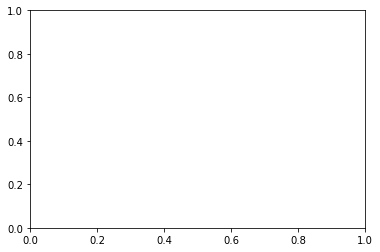

In [134]:
plot_relationship(df, select_country, variable, x_label, y_label, save_path)

In [4]:

import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, List, Union
from pathlib import Path
import os
def plot_relationship(df: pd.DataFrame,
                      select_country: Optional[List[str]] = None,
                      variable_1: Optional[List[str]] = None,
                      variable_2: Optional[List[str]] = None,
                      x_label: Optional[str] = None,
                      y_label: Optional[str] = None,
                      save_path: Optional[Path] = None) -> None:
    # convert 'Year' column to string type
    df['Year'] = df['Year'].astype(str)
    # filter by selected countries
    if select_country is not None:
        for country in select_country:
            country_df = df[df['Country Name'] == country]
            # check if both variables exist in the DataFrame
            if variable_1 is not None and variable_1[0] in country_df.columns and \
                    variable_2 is not None and variable_2[0] in country_df.columns:
                # plot the two variables on the same figure
                fig, ax1 = plt.subplots()
                ax1.plot(country_df['Year'], country_df[variable_1[0]], label=variable_1[0], color='b')
                ax1.set_xlabel(x_label or 'Year')
                ax1.set_ylabel(variable_1[0], color='b')
                ax1.tick_params(axis='y', labelcolor='b')

                ax2 = ax1.twinx()
                ax2.plot(country_df['Year'], country_df[variable_2[0]], label=variable_2[0], color='r')
                ax2.set_ylabel(variable_2[0], color='r')
                ax2.tick_params(axis='y', labelcolor='r')

                plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
                plt.xticks(country_df['Year'], rotation=90)
                plt.title(f'CVD Mortality and Prevalence of Tobacco Use in {country}')
                if save_path is not None:
                    if not os.path.exists(os.path.dirname(save_path)):
                        os.makedirs(os.path.dirname(save_path))
                    fig.savefig(save_path, dpi=300, bbox_inches='tight')

        plt_country = plt.show()
        
        return plt_country


if __name__ == '__main__':
    df = pd.read_excel(
        "/Users/wei/UCD-MPH/MPH-Lecture:Modules/MPH Dissertation/Data/19_ratified_country.xlsx")
    select_country = df['Country Name'].unique()
    variable_1 = ['CVD Mortality in Male (%)']
    variable_2 = ['Prevalence of Tobacco use in Male (age_standardized_rate) (%)']
    x_label = 'Year'
    y_label = 'CVD Mortality & Prevalence of Tobacco Use'
    save_path = '/Users/wei/Python/MPHDissertation/test_file/plot.png'
    df = plot_relationship(df, select_country=select_country, variable_1=variable_1, variable_2=variable_2,
                           x_label=x_label, y_label=y_label, save_path=save_path)
    if save_path is not None and os.path.isfile(save_path):
        print(f"{save_path} exists.")
    else:
        print(f"{save_path} does not exist.")



/Users/wei/Python/MPHDissertation/test_file/plot.png does not exist.
